In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

train_pas = train.copy()

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


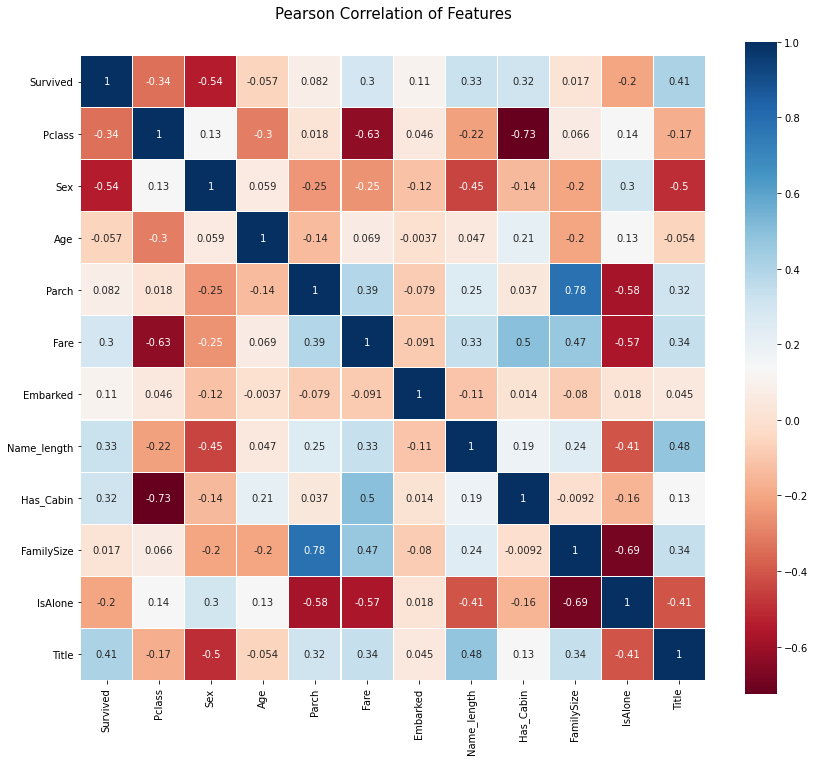

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

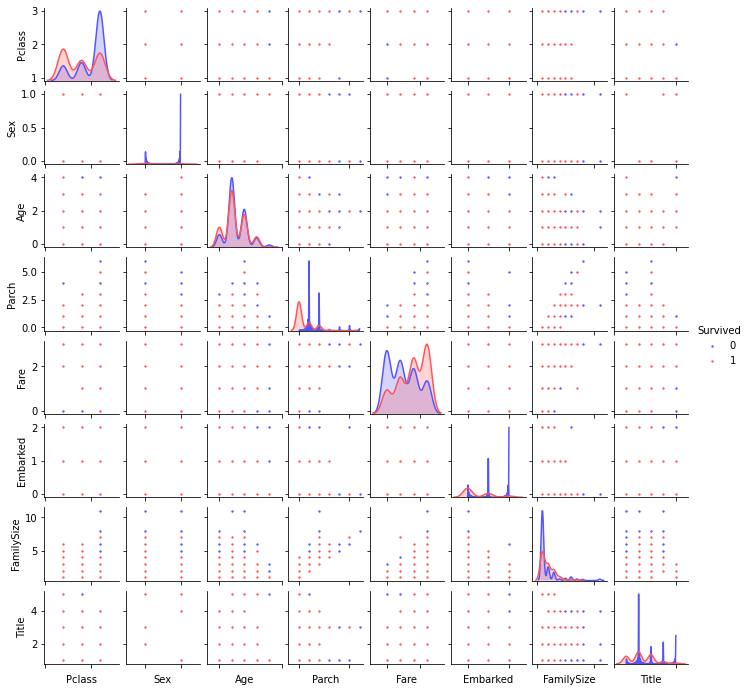

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Здесь используем алгоритм стекинга. В качестве базовых алгоритмов используем RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [8]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# параметры базовых алгоритмов

# GradientBoostingClassifier
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)}

# RandomForestClassifier
rfc_params = {'n_estimators': range(10, 100, 10),
              'min_samples_leaf': range(1, 5)}

# SVC
svc_params = {'kernel': ['linear', 'rbf'],
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [9]:
X = train.drop(columns='Survived')
y = train.Survived

x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17)

### 2.

In [10]:
# random_state
RS = 17

rfc = RandomForestClassifier(random_state=RS)
svc = SVC(random_state=RS)
gbc = GradientBoostingClassifier(random_state=RS)
lr = LogisticRegression(random_state=RS)

rfc_gs = GridSearchCV(rfc, rfc_params, cv=skf)
svc_gs = GridSearchCV(svc, svc_params, cv=skf)
gbc_gs = GridSearchCV(gbc, gbc_params, cv=skf)
lr_gs = GridSearchCV(lr, lr_params, cv=skf)

rfc_model = rfc_gs.fit(x_train, y_train)
rfc_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                           

In [11]:
svc_model = svc_gs.fit(x_train, y_train)
svc_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=17, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
gbc_model = gbc_gs.fit(x_train, y_train)
gbc_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
           

In [13]:
lr_model = lr_gs.fit(x_train, y_train)
lr_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [14]:
rfc_pred = rfc_model.predict(x_valid)
roc_auc_score(y_valid, rfc_pred)

0.7707293280541688

In [15]:
svc_pred = svc_model.predict(x_valid)
roc_auc_score(y_valid, svc_pred)

0.7775578125896597

In [16]:
gbc_pred = gbc_model.predict(x_valid)
roc_auc_score(y_valid, gbc_pred)

0.7600849256900212

In [17]:
lr_pred = lr_model.predict(x_valid)
roc_auc_score(y_valid, lr_pred)

0.7826074482125438

### 3.

In [18]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [19]:
CV = 5

model_pred = [rfc_pred, svc_pred, gbc_pred, lr_pred]

meta_mtrx = np.empty((x_valid.shape[0], len(model_pred)))

for n, model in enumerate(model_pred):
  meta_mtrx[:, n] = model

meta_alg = GridSearchCV(meta_mtrx, xgb_params, cv=CV)
meta_alg

GridSearchCV(cv=5, error_score=nan,
             estimator=array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]]),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'min_child_weight': range(1, 10),
                         'n_estimators': range(10, 100, 5),
                         'subsample': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### 4.

In [20]:
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier

In [21]:
gbc = GradientBoostingClassifier(learning_rate=0.1, random_state=RS)
rfc = RandomForestClassifier(min_samples_leaf=2, n_estimators=30, random_state=RS)
svc = SVC(C=0.9, kernel='rbf', random_state=RS)
lr = LogisticRegression(C=0.89, random_state=RS)
xgb = XGBClassifier(eta=0.1, min_child_weight=1, n_estimators=25, subsample=0.5)

models = [gbc, rfc, svc, lr]

x_train = train.drop(['Survived'], axis=1)
y_train = train.Survived

valid = np.empty((train.shape[0], len(models)))

for n, clf in enumerate(models):
    valid[:, n] = cross_val_predict(clf, x_train, y_train, cv=5, method='predict')
    clf.fit(x_train, y_train)

xgb.fit(valid, y_train)

meta_mtrx = np.empty((test.shape[0], len(models)))

for n, clf in enumerate(models):
    meta_mtrx[:, n] = clf.predict(test)

meta_predictions = xgb.predict(meta_mtrx)

### 5.
Файл посылка для Kaggle

In [22]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [23]:
write_to_submission_file(meta_predictions, train_pas.PassengerId)

### 6.
Каков результат score, полученного на соревновании?

Ответ: 0.76555
